# A walk through a Gradient Boosting Method : LightGBM


Microsoft's Light GBM is a gradient boosting framework that uses tree based learning algorithm. As opposed to other trees based algorithms, LightGBM grows leafwise rather than level-wise. With approach of max_delta loss it will choose the leaf to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm. 

LightGBM is efficient on large volume of data and has compatilbility configurations to run on a GPU as well. It provides for 3 parallel learning algorithms:

* Data parallel	


* Feature parallel


* Voting parallel



These provide for effective execution given different combinations of volume of Data and volume of features provided.
[Santander Value Challenge](https://www.kaggle.com/c/santander-value-prediction-challenge/data) provided with an anonymized dataset containing numeric feature variables, the numeric target column, and a string ID column.

The task was to predict the value of target column in the test set.

This notebook walks through the pipeline of:

* Exploratory Data Analysis (E.D.A.) including Data Preprocessing/Cleansing


* Normality test of **target** variable


* Dimensionality Reduction using PCA


* Modelling using LightGBM


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

In [2]:
%%time
train_df = pd.read_csv('./Data/train.csv')

CPU times: user 3.94 s, sys: 256 ms, total: 4.19 s
Wall time: 4.22 s


In [3]:
%%time
test_df = pd.read_csv('test.csv')

CPU times: user 54.9 s, sys: 8.42 s, total: 1min 3s
Wall time: 1min 6s


In [227]:
train_df.columns, len(train_df)

(Index([u'ID', u'target', u'48df886f9', u'0deb4b6a8', u'34b15f335',
        u'a8cb14b00', u'2f0771a37', u'30347e683', u'd08d1fbe3', u'6ee66e115',
        ...
        u'3ecc09859', u'9281abeea', u'8675bec0b', u'3a13ed79a', u'f677d4d13',
        u'71b203550', u'137efaa80', u'fb36b89d9', u'7e293fbaf', u'9fc776466'],
       dtype='object', length=4993), 4459)

There are 4993 columns and 4459 records for training with no name explanatory column names. 

## Exploratory Data Analysis (E.D.A.)

In [6]:
train_df.isnull().values.any()

False

**No Null Values recorded, so no need of imputation**

In [7]:
train_df.head(20)

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
5,002dbeb22,2800000.0,0.0,0,0.0,0,0,0,0,0,...,12000.0,5600000.0,20000000.0,0,0,0,0,0,0,11000
6,003925ac6,164000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,40000,0,0,0
7,003eb0261,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
8,004b92275,979000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,4000000.0,0,0,0,0,0,0,0
9,0067b4fef,460000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,400000


In [228]:
unique_value_columns =[col for col in train_df.columns if train_df[col].nunique(dropna=False)==1 ]
print 'No. of columns with single unique value:%s'%(len(unique_value_columns))

No. of columns with single unique value:256


**As the single unique values columns doesn't contribute to the output 'target', so it's better to drop them for computation efficiency.**

In [167]:
drop_train_df = train_df.drop(unique_value_columns,axis=1)
drop_test_df = test_df.drop(unique_value_columns,axis=1)

### Normality Test
**We'll inspect the distribution of 'target' variable first with some plots and then confirm with an Anderson-Darling Test.**

/Users/achyutajha/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


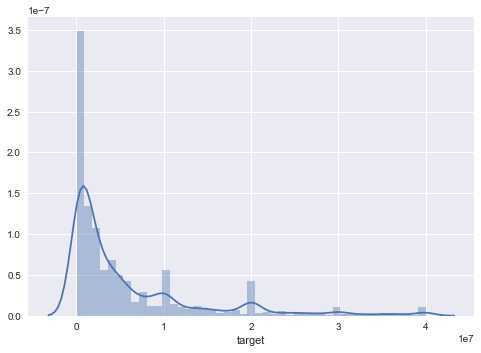

In [10]:
import seaborn as sns

sns.distplot(drop_train_df.target)

In [11]:
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt

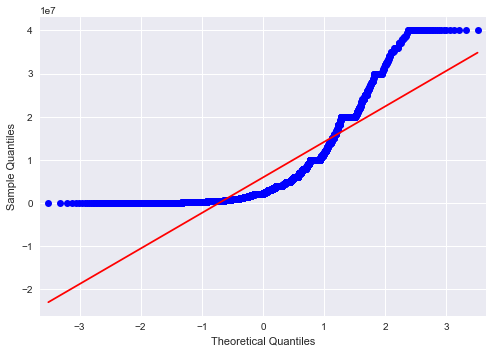

In [12]:
qqplot(drop_train_df.target, line='s')
plt.show()

**It is evident from the the plots that the distribution is clearly not Gaussian.**

In [236]:
from scipy.stats import anderson

print "Null Hypothesis(H0) : Data follows a Normal Distribution\n\n"
result = anderson(drop_train_df.target)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    print result.statistic , result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print'%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv)
    else:
        print'%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv)

Null Hypothesis(H0) : Data follows a Normal Distribution


Statistic: 433.534
433.533730964 0.575
15.000: 0.575, data does not look normal (reject H0)
433.533730964 0.655
10.000: 0.655, data does not look normal (reject H0)
433.533730964 0.786
5.000: 0.786, data does not look normal (reject H0)
433.533730964 0.917
2.500: 0.917, data does not look normal (reject H0)
433.533730964 1.091
1.000: 1.091, data does not look normal (reject H0)


"If the returned statistic is larger than these critical values then for the corresponding significance level, the null hypothesis that the data come from the chosen distribution can be rejected. "
Reference : https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html

**This infers that 'target' does not have a Normal Distribution**

### Data Preparation
**Prepare input by removing the prediction column 'target' as well as object data 'ID'.**

In [165]:
training_columns = list(drop_train_df.columns)
training_columns = set(training_columns).difference(['target','ID'])
len(training_columns)

4735

In [169]:
input_train_x = drop_train_df.loc[:,training_columns]
input_test_x = drop_test_df.loc[:,drop_test_df.columns!='ID']

In [231]:
input_test_x.shape, input_train_x.shape

((49342, 4735), (4459, 4735))

In [237]:
X = input_train_x
y = drop_train_df.target.values
y.shape

(4459,)

### Standardisation of Data
Data is standardised to a mean of 0 and standard deviation of 1, as data is from various scales and need to be brought in a uniform scale for better chance of convergence.

In [180]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler().fit(X)
scaler_y = StandardScaler().fit(y.reshape(-1, 1))
input_train_x = scaler_x.transform(X)
input_test_x = scaler_x.transform(input_test_x)
scaled_y = scaler_y.transform(y.reshape(-1, 1))

## Dimensionality reduction using PCA
Report features which account for 95% accountability in given data

In [64]:
from sklearn.decomposition import PCA
pca = PCA(.95)

In [183]:
pca.fit(input_train_x)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [184]:
pca.n_components_

1527

**From 4735 features, the feature set has narrowed down to 1527 features accounting for 95% accountability in given data**

In [185]:
pca_train_x = pca.transform(input_train_x)

In [186]:
pca_train_x.shape

(4459, 1527)

**Data Split ratio for Train/Test: 80/20**

In [243]:
from sklearn.model_selection import train_test_split
input_dev_x, val_x, input_dev_y, val_y = train_test_split(pca_train_x, scaled_y[:,0], test_size = 0.2)

In [244]:
input_dev_x.shape,input_dev_y.shape,val_x.shape,val_y.shape

((3567, 1527), (3567,), (892, 1527), (892,))

## Modelling using LightGBM

In [69]:
import lightgbm as lgb

In [70]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [245]:
#Prepare dataset for lgbm
input_train = lgb.Dataset(input_dev_x, label=input_dev_y)
input_val = lgb.Dataset(val_x,label=val_y,reference=input_train)

In [99]:
# params = {}
# params = {
#         "task": "train",
#         "objective" : "regression",
#         "boosting_type" : "gbdt",
#         "metric" : "mse",
#         "num_leaves" : 40,
#         "learning_rate" : 0.004,
#         "bagging_fraction" : 0.8,
#         "feature_fraction" : 0.4,
#         "bagging_frequency" : 6,
#         "bagging_seed" : 42,
#         "verbose" : 0,
#     ####################
#         "reg_sqrt" : True,
#         }

# # params['objective'] = 'regression'
# # params['learning_rate'] = 0.003
# # params['boosting_type'] = 'gbdt'
# # params['metric'] = 'mse'
# # params['sub_feature'] = 0.5
# # params['num_leaves'] = 50
# # params['min_data'] = 50
# # params['max_depth'] = 10
# # params['num_threads'] = cores
# # params['bagging_fraction'] = 0.6

In [135]:
unique_count = sorted([drop_train_df[col].nunique(dropna=False) for col in training_columns],reverse=True)
unique_count

[776,
 765,
 755,
 739,
 728,
 725,
 721,
 714,
 701,
 684,
 677,
 674,
 673,
 672,
 666,
 666,
 660,
 658,
 647,
 639,
 631,
 629,
 616,
 597,
 591,
 591,
 588,
 588,
 582,
 564,
 562,
 560,
 551,
 548,
 544,
 542,
 540,
 539,
 531,
 530,
 443,
 437,
 436,
 426,
 421,
 416,
 415,
 414,
 413,
 408,
 406,
 405,
 403,
 403,
 402,
 400,
 398,
 395,
 394,
 394,
 393,
 391,
 387,
 387,
 387,
 384,
 383,
 383,
 380,
 378,
 377,
 377,
 376,
 375,
 374,
 371,
 370,
 368,
 367,
 365,
 364,
 364,
 363,
 363,
 361,
 360,
 360,
 358,
 356,
 354,
 353,
 353,
 352,
 352,
 351,
 351,
 349,
 348,
 348,
 345,
 345,
 344,
 343,
 343,
 343,
 341,
 340,
 340,
 340,
 339,
 338,
 337,
 337,
 336,
 336,
 335,
 333,
 333,
 332,
 331,
 331,
 329,
 329,
 329,
 328,
 328,
 328,
 327,
 327,
 327,
 326,
 326,
 326,
 325,
 324,
 324,
 324,
 323,
 323,
 323,
 323,
 322,
 322,
 320,
 318,
 317,
 317,
 316,
 316,
 315,
 315,
 315,
 314,
 313,
 311,
 310,
 309,
 308,
 308,
 308,
 307,
 307,
 306,
 306,
 303,
 303,
 302

In [136]:
std_count = sorted([drop_train_df[col].std(axis=0) for col in training_columns],reverse=True)

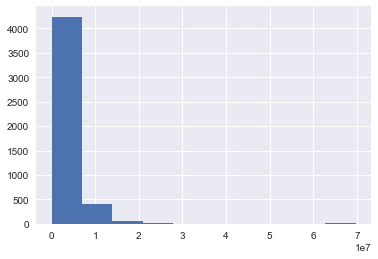

In [139]:
plt.hist(std_count)
plt.show()

In [118]:
len(drop_train_df),len(test_df)

(4459, 49342)

In [247]:
params = {}
params = {
        "task": "train",
        "objective" : "regression",
        "boosting_type" : "gbdt",
        "metric" : "mse",
        "num_leaves" : 35,
        "learning_rate" : 0.005,
        "bagging_fraction" : 0.8,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbose" : 0,
        "tree_learner" : "feature",
        "num_threads" : cores
}


In [248]:
evals_result = {} 

lgbm_model = lgb.train(params, input_train,
                       valid_sets=[input_train,input_val],
                       evals_result=evals_result,
                       num_boost_round=4000, 
                       early_stopping_rounds=200,
                       verbose_eval=200)

Training until validation scores don't improve for 200 rounds.
[200]	training's l2: 0.553407	valid_1's l2: 0.834133
[400]	training's l2: 0.355775	valid_1's l2: 0.800909
[600]	training's l2: 0.239855	valid_1's l2: 0.788883
[800]	training's l2: 0.165148	valid_1's l2: 0.782824
[1000]	training's l2: 0.115339	valid_1's l2: 0.779207
[1200]	training's l2: 0.0817027	valid_1's l2: 0.776659
[1400]	training's l2: 0.0587062	valid_1's l2: 0.774604
[1600]	training's l2: 0.0427359	valid_1's l2: 0.773629
[1800]	training's l2: 0.0313229	valid_1's l2: 0.772957
[2000]	training's l2: 0.0231797	valid_1's l2: 0.772525
[2200]	training's l2: 0.0173125	valid_1's l2: 0.771636
[2400]	training's l2: 0.0130598	valid_1's l2: 0.771103
[2600]	training's l2: 0.00989243	valid_1's l2: 0.770469
[2800]	training's l2: 0.00753432	valid_1's l2: 0.770146
[3000]	training's l2: 0.00576078	valid_1's l2: 0.770023
[3200]	training's l2: 0.00442305	valid_1's l2: 0.769837
[3400]	training's l2: 0.0034088	valid_1's l2: 0.769624
Early s

In [249]:
lgbm_model.best_iteration

3394

Plotting feature importances...


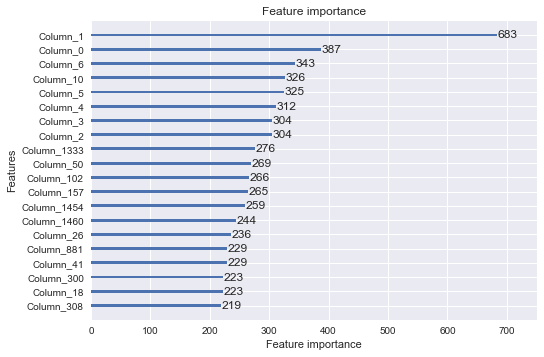

In [250]:
print('Plotting feature importances...')
ax = lgb.plot_importance(lgbm_model, max_num_features=20)
plt.show()

In [100]:
from sklearn.metrics import mean_squared_error, r2_score
def metrics_eval(val_y, target_predictions):
    print("Mean squared error: %.2f"% mean_squared_error(val_y, target_predictions))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(val_y, target_predictions))

In [251]:
target_predictions = lgbm_model.predict(val_x)

In [252]:
metrics_eval(val_y, target_predictions)

Mean squared error: 0.77
Variance score: 0.22


In [253]:
print("Features Importance...")
gain = lgbm_model.feature_importance('gain')
featureimp = pd.DataFrame({'feature':lgbm_model.feature_name(), 
                   'split':lgbm_model.feature_importance('split'), 
                   'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print(featureimp[:50])

Features Importance...
          feature      gain  split
1        Column_1  9.263667    683
2        Column_2  3.303726    304
5        Column_5  2.742066    325
6        Column_6  1.091807    343
0        Column_0  0.863049    387
157    Column_157  0.808657    265
3        Column_3  0.775901    304
102    Column_102  0.612791    266
136    Column_136  0.585382    131
7        Column_7  0.552793    215
217    Column_217  0.538028    209
50      Column_50  0.512558    269
14      Column_14  0.481220    212
4        Column_4  0.431363    312
27      Column_27  0.397108    179
242    Column_242  0.382198    211
348    Column_348  0.381591     89
53      Column_53  0.360474    127
304    Column_304  0.338751    195
18      Column_18  0.322254    223
21      Column_21  0.312181    118
54      Column_54  0.311005    202
8        Column_8  0.308771    180
185    Column_185  0.298208    193
35      Column_35  0.292129    186
112    Column_112  0.274544    102
1526  Column_1526  0.266598    1

Plotting metrics recorded during training...


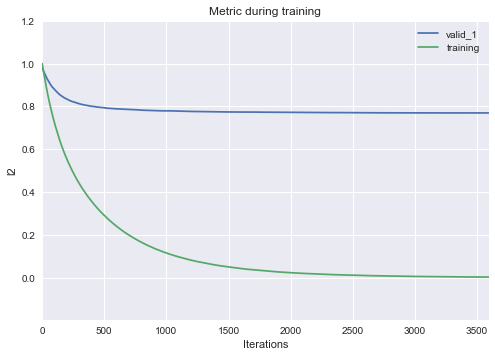

In [256]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='l2')
plt.show()

In [106]:
lgbm_model.save_model('LGBMRegressorModel.txt')

## GridSearchCV for hyperparameter tuning

In [258]:
param={}
param["learning_rate"] = [0.01,0.005]
param["num_leaves"] = [20,25,35]
param["bagging_fraction"] = [0.7,0.9]
param["bagging_frequency"] = [10,15]

In [259]:
params = {}
params = {
        "task": ["train"],
        "objective" : ["regression"],
        "boosting_type" : ["gbdt"],
        "metric" : ["mse"],
        "num_leaves" : param["num_leaves"],
        "learning_rate" : param["learning_rate"],
        "bagging_fraction" : param["bagging_fraction"],
        "feature_fraction" : [0.7],
        "bagging_frequency" : param["bagging_frequency"],
        "bagging_seed" : [42],
        "verbose" : [0],
        "tree_learner" : ["feature"],
        "num_threads" : [cores],
        "num_boost_round" : [4000],
        "eval_metric" : ["l2"]
    }

In [260]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit

# 0 index for validation and -1 for dev
data_fold = list()
data_fold = [-1]*len(input_dev_x)
data_fold.extend([0]*len(val_x))
ps = PredefinedSplit(data_fold)

gbm = GridSearchCV(lgb.LGBMRegressor(), param_grid=params, cv=ps)

In [261]:
ps.get_n_splits()

1

In [262]:
gbm.fit(pca_train_x, scaled_y[:,0])

print('Best parameters found by grid search are:', gbm.best_params_)


('Best parameters found by grid search are:', {'bagging_seed': 42, 'num_threads': 4, 'verbose': 0, 'eval_metric': 'l2', 'num_leaves': 25, 'learning_rate': 0.005, 'bagging_frequency': 10, 'task': 'train', 'objective': 'regression', 'num_boost_round': 4000, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'metric': 'mse', 'tree_learner': 'feature', 'boosting_type': 'gbdt'})


In [263]:
pred_y = gbm.predict(val_x)
mean_squared_error(val_y,pred_y)

0.018157023719776927

## Scaling back Y values to original scale

In [266]:
rescaled_pred_y = scaler_y.inverse_transform(pred_y)

# Conclusion

The mean_squared_error was brought down to from 0.77 to 0.018 with the hyperparameter tuning. Essentially, the parameters:

**num_leaves**, **max_depth** of the tree help to control the overfitting. 

**bagging_fraction** fraction of features considered to make the split at a node

**bagging_frequency** bagging from trees at every specified frequency

This was a walk-through LightGBM for a regression problem with a large number of features. 

# References
* https://lightgbm.readthedocs.io/en/latest/index.html
* https://github.com/Microsoft/LightGBM

